In [2]:
# If you don't already have it...
#import sys
#!{sys.executable} -m pip install nflows
#!{sys.executable} -m pip install uproot

### Trying to flow from a Gaussian to the LHCb Log10(IP) shape

* The LHCb simulation log10(IP) shape is kinda Gaussian. We want to flow from a Gaussian to there.
* The step after that would be to invert the flow (that is part of their properties), from there to Gaussian.
* A similar flow should be able to flow from Gaussian -> Z IP data shape. 
* Thus you have a 2-step flow procedure of simulation -> Gaussian -> data, which is the transformation we want to learn.

In [3]:
# Let's first load up the simulated data and put it into a 1D numpy array
import numpy as np
import uproot

file = uproot.open("../data/tuple_for_training__DATA.root")
muon_prefix = "mup_"
branch = f'{muon_prefix}IP'
selection = "(1>0)"
sim_ip = file['DecayTree'].arrays(
    branch, cut=selection, library='np')[branch].astype(np.float64)

N_SAMPLES = 10000
sim_log10_ip = np.log10(sim_ip)
# take first N_SAMPLES from sim_log10_ip
sim_log10_ip = sim_log10_ip[:, :N_SAMPLES]
print(sim_log10_ip.shape)

(1, 10000)


In [4]:
import matplotlib.pyplot as plt

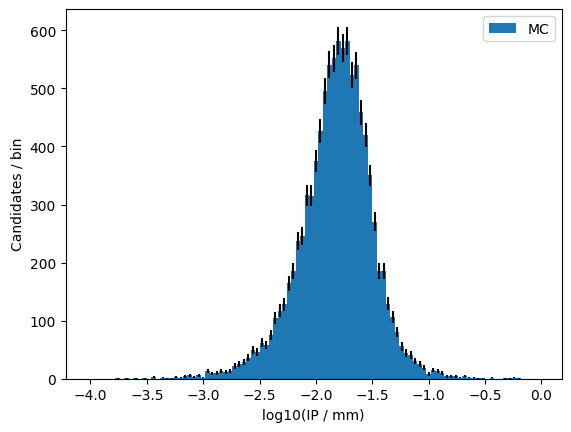

In [5]:
fig, ax = plt.subplots()
hist_mc, bins = np.histogram(sim_log10_ip, bins=100, range=(-4, 0))
bin_centers = (bins[:-1] + bins[1:]) / 2
ax.bar(x=bins[:-1], height=hist_mc, yerr=np.sqrt(hist_mc), width=bins[1] - bins[0], label='MC')
ax.set_xlabel('log10(IP / mm)')
ax.set_ylabel('Candidates / bin')
ax.legend()
plt.show()


Now we've got the data loaded in, and it looks about right.
Next step is just instance a 1D flow as before.

In [6]:
from nflows import transforms, distributions, flows
import torch

In [7]:
# Define an invertible transformation.
# Need to learn what these transforms do/why we might want to use these.
# This time it's a 1D transform, so just 1 input and output feature.
N_FEATURES = 1
transform = transforms.CompositeTransform([
    transforms.MaskedAffineAutoregressiveTransform(features=N_FEATURES, hidden_features=4),
    transforms.RandomPermutation(features=N_FEATURES)
])

# Define a base distribution.
base_distribution = distributions.StandardNormal(shape=[N_FEATURES])
print(base_distribution)

# Combine into a flow.
flow = flows.Flow(transform=transform, distribution=base_distribution)
print(flow)


StandardNormal()
Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=1, out_features=4, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x MaskedResidualBlock(
              (linear_layers): ModuleList(
                (0-1): 2 x MaskedLinear(in_features=4, out_features=4, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=4, out_features=2, bias=True)
        )
      )
      (1): RandomPermutation()
    )
  )
  (_distribution): StandardNormal()
  (_embedding_net): Identity()
)


Let's take a look at the standard normal

<class 'torch.Tensor'>
torch.Size([1000, 1])
tensor([[ 1.9269],
        [ 1.4873],
        [ 0.9007],
        [-2.1055],
        [ 0.6784],
        [-1.2345],
        [-0.0431],
        [-1.6047],
        [-0.7521],
        [ 1.6487]])


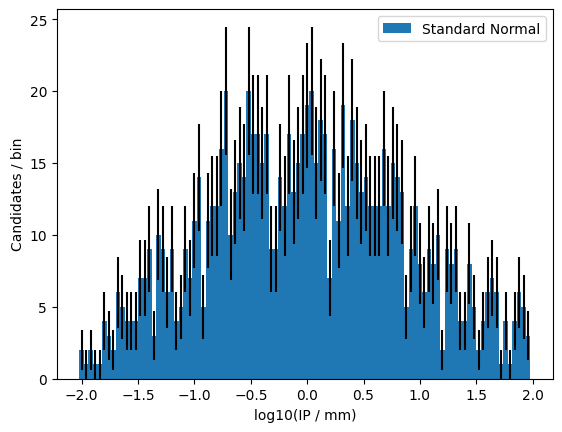

In [8]:
torch.manual_seed(42)
with torch.inference_mode():
    num_samples = 1000
    samples = base_distribution.sample(num_samples)
    print(type(samples))
    print(samples.shape)
    print(samples[:10])

    # Gotta plot them 
    normal_hist, norm_bins = np.histogram(samples, bins=100, range=(-2, 2))
    plt.bar(x=norm_bins[:-1], height=normal_hist, yerr=np.sqrt(normal_hist), width=norm_bins[1] - norm_bins[0], label='Standard Normal')
    plt.xlabel('log10(IP / mm)')
    plt.ylabel('Candidates / bin')
    plt.legend()
    plt.show()

Looks fairly Gaussian to me.
Let's try to train the flow.

In [9]:
# Prepare the target data
# Reshape was needed to swap the axes to match what the flow expects
sim_log10_ip_tensor = torch.tensor(sim_log10_ip, dtype=torch.float32).reshape(-1, 1)
print(sim_log10_ip_tensor[:5])
print(sim_log10_ip_tensor.shape)
print(samples[:5])
print(samples.shape)


tensor([[-1.9285],
        [-1.4633],
        [-1.6164],
        [-1.8332],
        [-2.0260]])
torch.Size([10000, 1])
tensor([[ 1.9269],
        [ 1.4873],
        [ 0.9007],
        [-2.1055],
        [ 0.6784]])
torch.Size([1000, 1])


Loss at iteration 0: 3.231956720352173


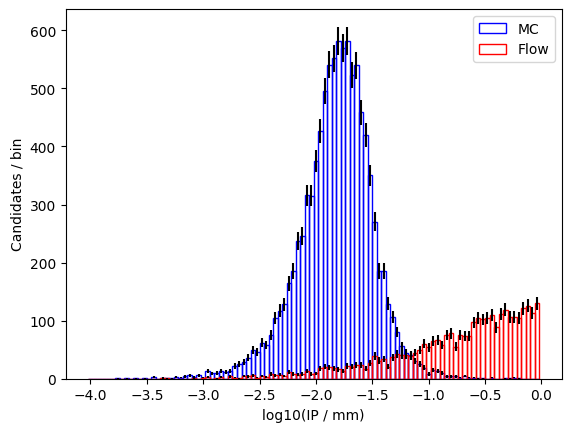

Loss at iteration 200: 1.04520845413208


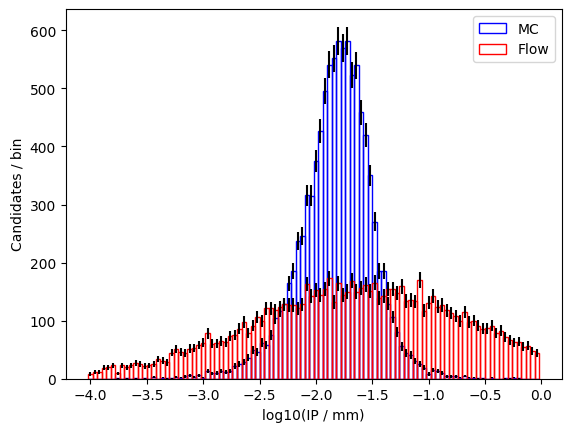

Loss at iteration 400: 0.33489471673965454


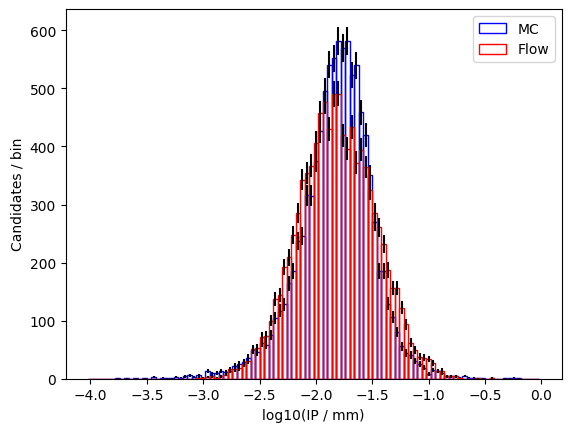

Loss at iteration 600: 0.33489471673965454


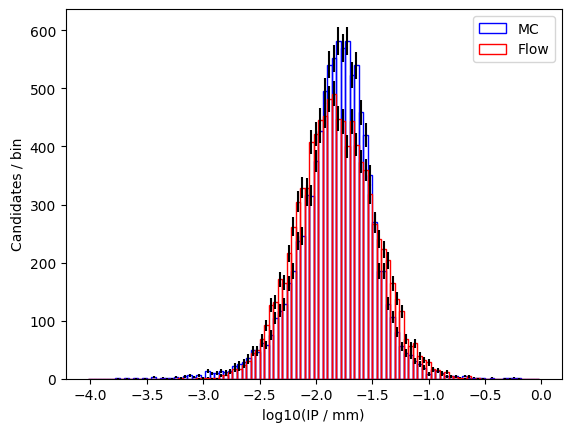

Loss at iteration 800: 0.33489465713500977


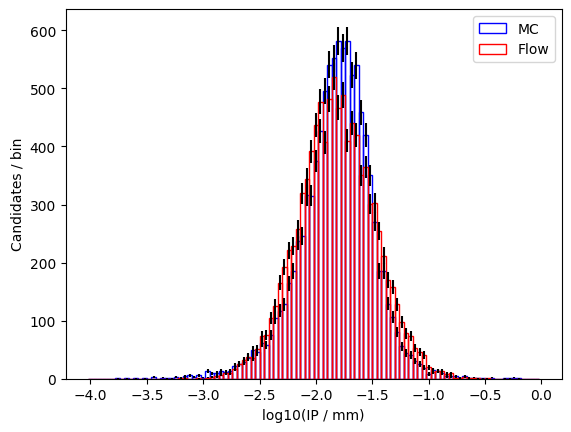

In [10]:
from torch import optim, nn
optimizer = optim.Adam(flow.parameters())
n_iter = 1000
for i in range(n_iter):
    #flow.train() # Put it in training mode.

    # TODO Need to understand why we zero_grad() before calculating the loss.
    # TODO also need to undestand the loss
    # TODO why no forward pass? 
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=sim_log10_ip_tensor).mean()
    loss.backward()
    optimizer.step()

    ### Testing the thing
    # flow.eval() # Put it in evaluation mode.
    with torch.inference_mode():
        if i % (n_iter/5) == 0:
            print(f"Loss at iteration {i}: {loss}")

            # Plot the target
            fig, ax = plt.subplots()
            #hist_mc, bins = np.histogram(sim_log10_ip, bins=100, range=(-4, 0))
            #bin_centers = (bins[:-1] + bins[1:]) / 2
            # Already did all that above
            ax.bar(x=bins[:-1], height=hist_mc, yerr=np.sqrt(hist_mc), width=bins[1] - bins[0], label='MC', fill=False, edgecolor='blue')
            ax.set_xlabel('log10(IP / mm)')
            ax.set_ylabel('Candidates / bin')

            # Sample from the flow and plot the histogram
            samples = flow.sample(N_SAMPLES)
            pred_hist, bins = np.histogram(samples, bins=100, range=(-4, 0))
            ax.bar(x=bins[:-1], height=pred_hist, yerr=np.sqrt(pred_hist), width=bins[1] - bins[0], label='Flow', fill=False, edgecolor='red')

            ax.legend()
            plt.show()

So this kinda seems to be working, but it looks like we have a normalisation problem...
Let's try to take the same number of target samples as what we take from the flow.
This should also speed up the training...

Now I've adjusted the normalisations, we can see that the two distributions are getting quite close!
We probably want to do some kind of chi2 metric as the loss function to optimise...

**Let's try to train using a more well-known metric**
Currently training with an Adam optimizer and the loss is `-flow.log_prob(inputs=sim_log10_ip_tensor).mean()`. I think something like a chi2 is a better suited loss/metric with which to optimise the flow, but we first have to understand a bit more about what the loss function has to look like, and what this current loss function is and why it has been picked. 

* *What it currently is*:
    What is actually being calculated seems to the KL divergence, as described in eqn 14 of [the NFlows paper](https://arxiv.org/pdf/1912.02762). We can see that the `_log_prob` method (see code [here](https://github.com/bayesiains/nflows/blob/master/nflows/flows/base.py#L49)) of a flow evaluates a log of the probabilities for all the inputs you give it. log(prob) for a Gaussian is the Gaussian's exponent i.e. `(x - mu / 2 sigma**2 )**2`. We see something like that happening in the `StandardNormal`'s `_log_prob` function [here](https://github.com/bayesiains/nflows/blob/master/nflows/distributions/normal.py#L23). 
    Then we complete eqn 14 from the paper by taking this sum of log probabilities over the inputs and turning it into a mean.  

How about we just train a little longer... 

Loss at iteration 0: 0.33489471673965454


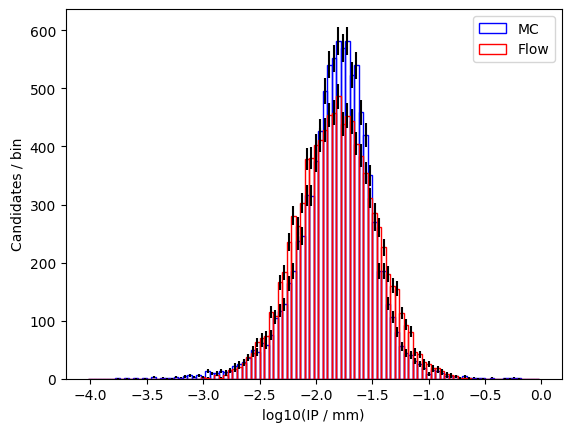

Loss at iteration 200: 0.33489471673965454


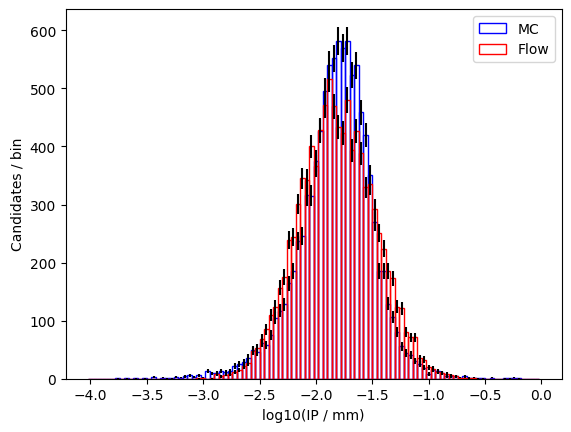

Loss at iteration 400: 0.33489468693733215


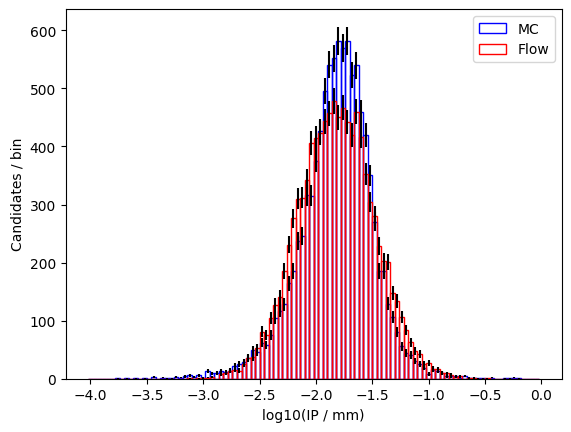

Loss at iteration 600: 0.33489468693733215


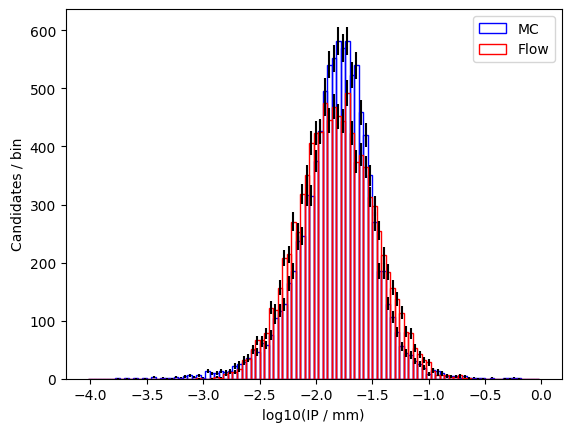

Loss at iteration 800: 0.33489468693733215


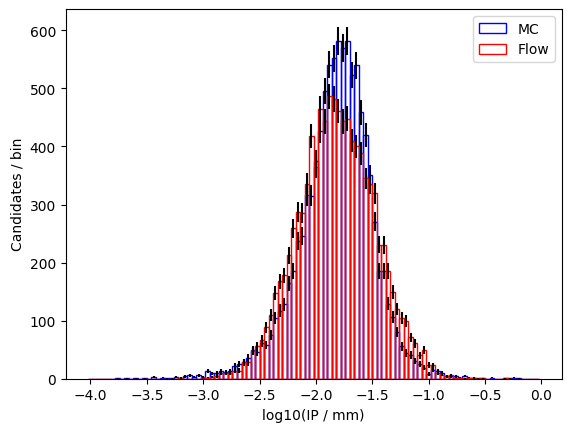

In [11]:
n_iter = 1000
for i in range(n_iter):
    #flow.train() # Put it in training mode.

    # TODO Need to understand why we zero_grad() before calculating the loss.
    # TODO also need to undestand the loss
    # TODO why no forward pass? 
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=sim_log10_ip_tensor).mean()
    loss.backward()
    optimizer.step()

    ### Testing the thing
    # flow.eval() # Put it in evaluation mode.
    with torch.inference_mode():
        if i % (n_iter/5) == 0:
            print(f"Loss at iteration {i}: {loss}")

            # Plot the target
            fig, ax = plt.subplots()
            #hist_mc, bins = np.histogram(sim_log10_ip, bins=100, range=(-4, 0))
            #bin_centers = (bins[:-1] + bins[1:]) / 2
            # Already did all that above
            ax.bar(x=bins[:-1], height=hist_mc, yerr=np.sqrt(hist_mc), width=bins[1] - bins[0], label='MC', fill=False, edgecolor='blue')
            ax.set_xlabel('log10(IP / mm)')
            ax.set_ylabel('Candidates / bin')

            # Sample from the flow and plot the histogram
            samples = flow.sample(N_SAMPLES)
            pred_hist, bins = np.histogram(samples, bins=100, range=(-4, 0))
            ax.bar(x=bins[:-1], height=pred_hist, yerr=np.sqrt(pred_hist), width=bins[1] - bins[0], label='Flow', fill=False, edgecolor='red')

            ax.legend()
            plt.show()

The flow is not really improving... Perhaps we tweak the parameters of the optimizer... It has a [default learning rate](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) of 0.001. Now that we are near the solution, perhaps we keep going but with a slower learning rate...

Loss at iteration 0: 0.33489468693733215


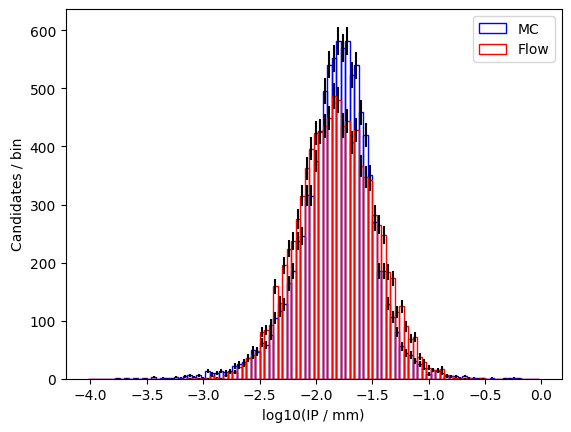

Loss at iteration 200: 0.33489465713500977


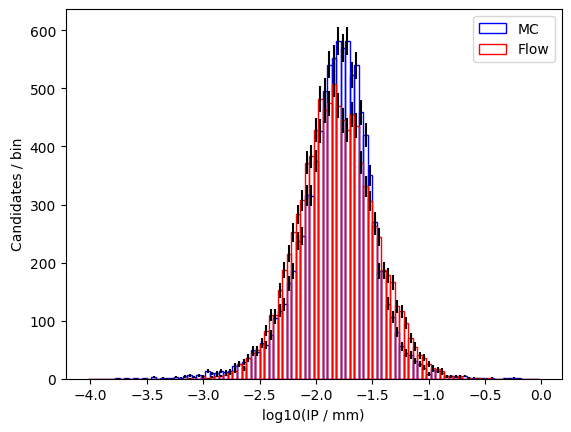

Loss at iteration 400: 0.33489471673965454


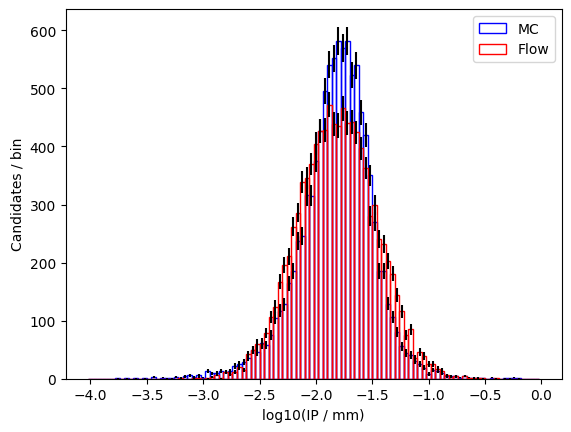

Loss at iteration 600: 0.33489471673965454


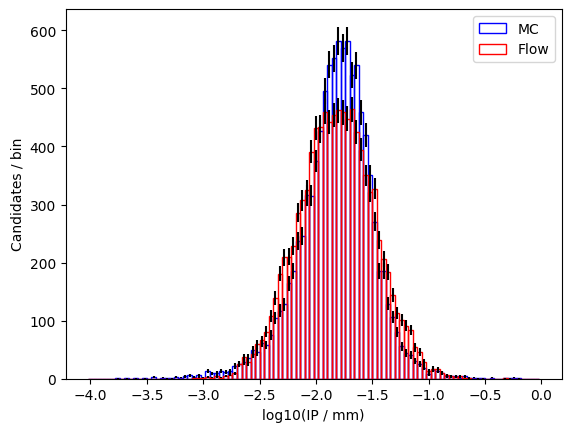

Loss at iteration 800: 0.3348946273326874


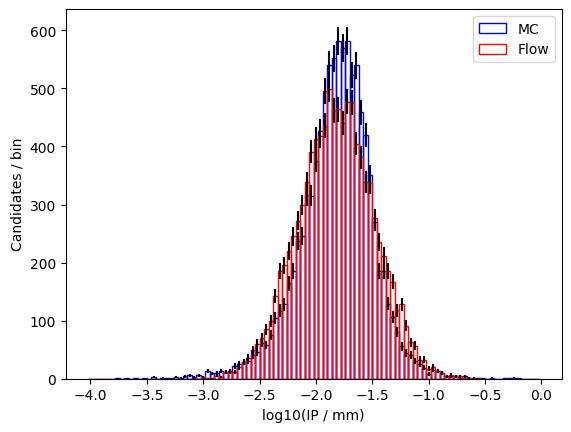

In [12]:
optimizer = optim.Adam(flow.parameters(), lr=1e-5)
n_iter = 1000
for i in range(n_iter):
    #flow.train() # Put it in training mode.

    # TODO Need to understand why we zero_grad() before calculating the loss.
    # TODO also need to undestand the loss
    # TODO why no forward pass? 
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=sim_log10_ip_tensor).mean()
    loss.backward()
    optimizer.step()

    ### Testing the thing
    # flow.eval() # Put it in evaluation mode.
    with torch.inference_mode():
        if i % (n_iter/5) == 0:
            print(f"Loss at iteration {i}: {loss}")

            # Plot the target
            fig, ax = plt.subplots()
            #hist_mc, bins = np.histogram(sim_log10_ip, bins=100, range=(-4, 0))
            #bin_centers = (bins[:-1] + bins[1:]) / 2
            # Already did all that above
            ax.bar(x=bins[:-1], height=hist_mc, yerr=np.sqrt(hist_mc), width=bins[1] - bins[0], label='MC', fill=False, edgecolor='blue')
            ax.set_xlabel('log10(IP / mm)')
            ax.set_ylabel('Candidates / bin')

            # Sample from the flow and plot the histogram
            samples = flow.sample(N_SAMPLES)
            pred_hist, bins = np.histogram(samples, bins=100, range=(-4, 0))
            ax.bar(x=bins[:-1], height=pred_hist, yerr=np.sqrt(pred_hist), width=bins[1] - bins[0], label='Flow', fill=False, edgecolor='red')

            ax.legend()
            plt.show()

Still not improving... I think it may have dragged itself into a local minimum, but not the best. How about with a high learning rate again?

Loss at iteration 0: 0.33489471673965454


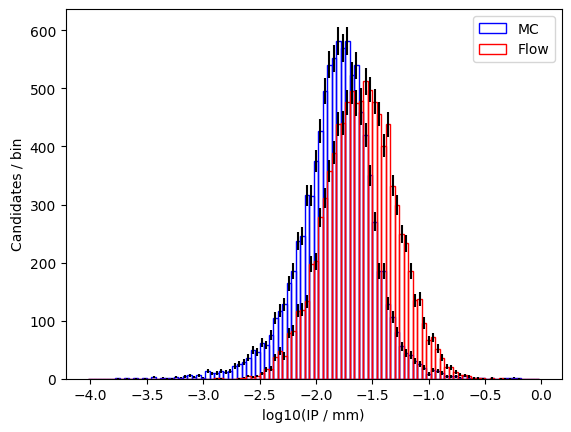

Loss at iteration 200: 0.33489465713500977


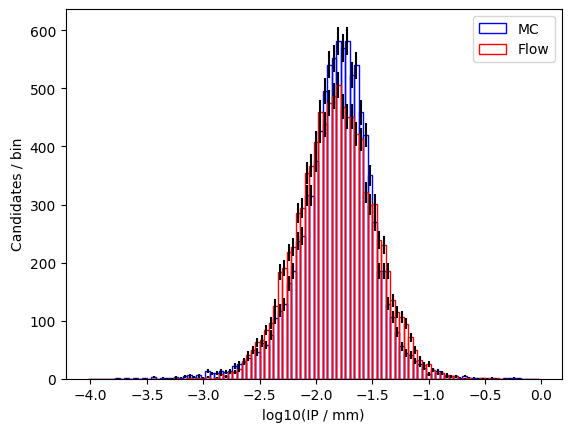

Loss at iteration 400: 0.3348946273326874


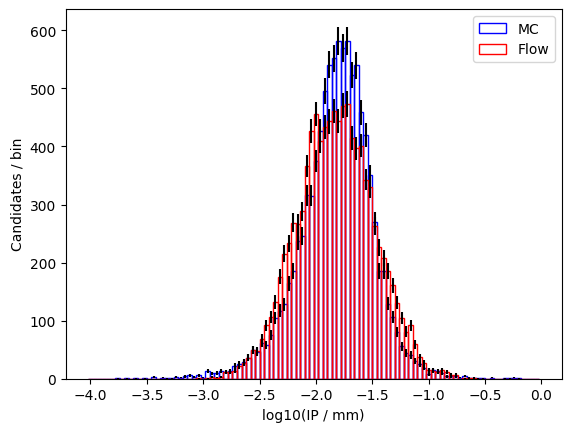

Loss at iteration 600: 0.33489471673965454


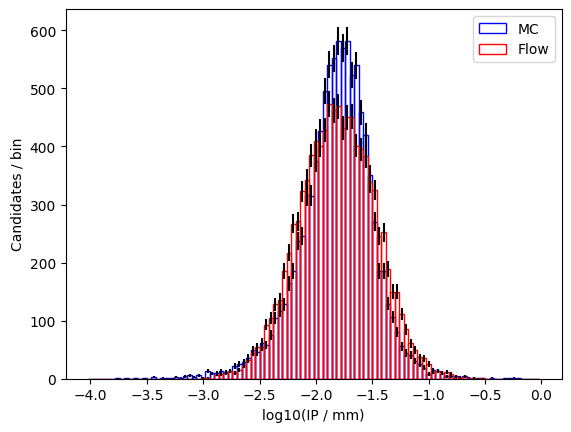

Loss at iteration 800: 0.33489468693733215


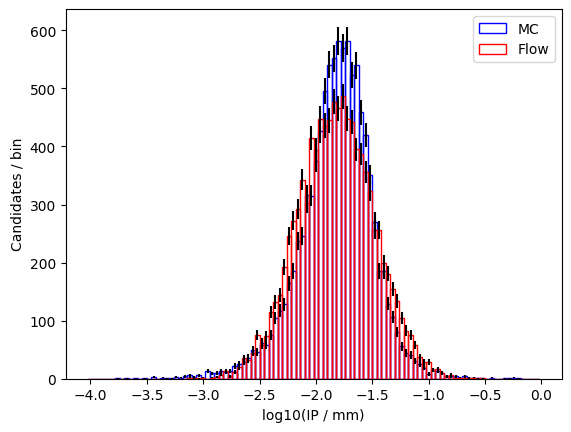

In [13]:
optimizer = optim.Adam(flow.parameters(), lr=1e-2)
n_iter = 1000
for i in range(n_iter):
    #flow.train() # Put it in training mode.

    # TODO Need to understand why we zero_grad() before calculating the loss.
    # TODO also need to undestand the loss
    # TODO why no forward pass? 
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=sim_log10_ip_tensor).mean()
    loss.backward()
    optimizer.step()

    ### Testing the thing
    # flow.eval() # Put it in evaluation mode.
    with torch.inference_mode():
        if i % (n_iter/5) == 0:
            print(f"Loss at iteration {i}: {loss}")

            # Plot the target
            fig, ax = plt.subplots()
            #hist_mc, bins = np.histogram(sim_log10_ip, bins=100, range=(-4, 0))
            #bin_centers = (bins[:-1] + bins[1:]) / 2
            # Already did all that above
            ax.bar(x=bins[:-1], height=hist_mc, yerr=np.sqrt(hist_mc), width=bins[1] - bins[0], label='MC', fill=False, edgecolor='blue')
            ax.set_xlabel('log10(IP / mm)')
            ax.set_ylabel('Candidates / bin')

            # Sample from the flow and plot the histogram
            samples = flow.sample(N_SAMPLES)
            pred_hist, bins = np.histogram(samples, bins=100, range=(-4, 0))
            ax.bar(x=bins[:-1], height=pred_hist, yerr=np.sqrt(pred_hist), width=bins[1] - bins[0], label='Flow', fill=False, edgecolor='red')

            ax.legend()
            plt.show()

In that case I think we do have to define a chi2 loss function.

### Chi2 loss function
...and also try to be a bit more functional/a serious programmer now.

In [14]:
def chi2_loss(y_true: np.histogram, y_pred: np.histogram):
    return torch.sum((y_true - y_pred)**2 / y_true)

def train_flow(flow, optimizer, target_data, n_iter):
    #flow.train() # Put it in training mode.
    def to_hist(data):
        return np.histogram(data, bins=100, range=(-4, 0))

    for i in range(n_iter):
        optimizer.zero_grad()
        pred_data = flow.sample(target_data.shape[0])
        target_hist = to_hist(target_data.detach().numpy())
        pred_hist = to_hist(pred_data.detach().numpy())
        loss = chi2_loss(target_hist, pred_hist)
        loss.backward()
        optimizer.step()
        ### Testing the thing
        # flow.eval() # Put it in evaluation mode.
        with torch.inference_mode():
            if i % (n_iter/5) == 0:
                print(f"Loss at iteration {i}: {loss}")

                # Plot the target
                fig, ax = plt.subplots()
                hist_target, bins = np.histogram(target_data, bins=100, range=(-4, 0))

                ax.bar(x=bins[:-1], height=hist_target, yerr=np.sqrt(hist_target), width=bins[1] - bins[0], label='MC', fill=False, edgecolor='blue')
                ax.set_xlabel('log10(IP / mm)')
                ax.set_ylabel('Candidates / bin')

                pred_hist, bins = np.histogram(pred_data, bins=100, range=(-4, 0))
                ax.bar(x=bins[:-1], height=pred_hist, yerr=np.sqrt(pred_hist), width=bins[1] - bins[0], label='Flow', fill=False, edgecolor='red')

                ax.legend()
                plt.show()

In [15]:
# Will have to redefine a new flow that hasn't already been trained
def make_flow():
    N_FEATURES = 1
    transform = transforms.CompositeTransform([
        transforms.MaskedAffineAutoregressiveTransform(features=N_FEATURES, hidden_features=4),
        transforms.RandomPermutation(features=N_FEATURES)
    ])
    base_distribution = distributions.StandardNormal(shape=[N_FEATURES])
    return flows.Flow(transform=transform, distribution=base_distribution)

In [16]:
# Working out how to get histograms...
hist_sample = flow.sample(N_SAMPLES)
pred_hist = torch.histc(hist_sample,
                         bins=100,
                         min=-4,
                            max=0)
print(pred_hist)
print(type(pred_hist))

# torch.histogram provides an awkward return type, so we'll use torch.histc instead
# pred_hist2 = torch.histogram(hist_sample, bins=100, range=(-4, 0)) 
pred_hist2 = torch.histc(flow.sample(N_SAMPLES), bins=100, min=-4, max=0)
#print(pred_hist2)
# print(type(pred_hist))

#pred_hist2 = torch.histc(flow.sample(N_SAMPLES), bins=100, range=(-4, 0))
# print(pred_hist2)
# These two histos are indeed different thanks to the random sampling

# Can we subtract them?
resid = pred_hist - pred_hist2
print(resid)
#torch.sub(pred_hist, pred_hist2)
#print(pred_hist)

# pred_hist_tensor = torch.Tensor(pred_hist)
# print(pred_hist_tensor)

# plt.bar(x=bins[:-1],
#        height=pred_hist,
#        yerr=torch.sqrt(pred_hist),
#        width=bins[1] - bins[0],
#        label='Flow',
#        fill=False,
#        edgecolor='red')
# plt.show()

tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   2.,
          0.,   1.,   0.,   4.,   2.,   2.,   8.,   9.,  11.,  16.,  29.,  37.,
         46.,  47.,  76.,  80., 120., 117., 153., 186., 226., 194., 283., 312.,
        347., 402., 393., 423., 451., 486., 478., 486., 486., 449., 440., 389.,
        394., 342., 353., 293., 268., 218., 193., 142., 134.,  98.,  92.,  79.,
         63.,  31.,  36.,  18.,  15.,  14.,   4.,   6.,   4.,   4.,   3.,   1.,
          1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.])
<class 'torch.Tensor'>
tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   2.,
         -1.,  -1.,  -1.,   1.,  -4.,  -2.,   1.,  -2.,   0.,  -3.,  13.,   9.,
          8., -23.,   7., -13.,  16., -19., -13.,   7.,  -2., -4

In [17]:
def chi2_loss(y_true, y_pred):
    # First histogram the data
    pred_hist = torch.histc(y_pred, bins=100, min=-4, max=0)
    true_hist = torch.histc(y_true, bins=100, min=-4, max=0)
    return torch.sum((true_hist - pred_hist)**2 / true_hist)

In [18]:
def train_flow(flow, optimizer, target_data, n_iter):
    #flow.train() # Put it in training mode.
    for i in range(n_iter):
        optimizer.zero_grad()
        pred_data = flow.sample(target_data.shape[0])
        loss = chi2_loss(target_data, pred_data)
        loss.backward()
        optimizer.step()
        ### Testing the thing
        # flow.eval() # Put it in evaluation mode.
        with torch.inference_mode():
            if i % (n_iter/5) == 0:
                print(f"Loss at iteration {i}: {loss}")

                # Plot the target
                fig, ax = plt.subplots()
                hist_target, bins = np.histogram(target_data, bins=100, range=(-4, 0))

                ax.bar(x=bins[:-1], height=hist_target, yerr=np.sqrt(hist_target), width=bins[1] - bins[0], label='MC', fill=False, edgecolor='blue')
                ax.set_xlabel('log10(IP / mm)')
                ax.set_ylabel('Candidates / bin')

                pred_hist, bins = np.histogram(pred_data, bins=100, range=(-4, 0))
                ax.bar(x=bins[:-1], height=pred_hist, yerr=np.sqrt(pred_hist), width=bins[1] - bins[0], label='Flow', fill=False, edgecolor='red')

                ax.legend()
                plt.show()

In [19]:
flow = make_flow()
n_iter = 1000
optimizer = optim.Adam(flow.parameters())
train_flow(flow, optimizer, sim_log10_ip_tensor, n_iter)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

We seem to be struggling. To be fair, you have to remember that this is all a neural network under-the-hood, and so histogramming those data points that go into
it is a bit weird. 

We could indeed histogram the data to plot it, and as part of testing evaluate a *test chi2*, but I think we need a loss function that is unbinned. 

So perhaps the next question is: why is my thing not working? Maybe I just need more hidden features?

In [20]:
# Will have to redefine a new flow that hasn't already been trained
def make_flow(hidden_features=4):
    N_FEATURES = 1
    transform = transforms.CompositeTransform([
        transforms.MaskedAffineAutoregressiveTransform(features=N_FEATURES, hidden_features=hidden_features),
        transforms.RandomPermutation(features=N_FEATURES)
    ])
    base_distribution = distributions.StandardNormal(shape=[N_FEATURES])
    return flows.Flow(transform=transform, distribution=base_distribution)

In [21]:
def train_flow_old_style(flow, optimizer, target_data, n_iter):
    #flow.train() # Put it in training mode.
    for i in range(n_iter):
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs=target_data).mean()
        loss.backward()
        optimizer.step()
        ### Testing the thing
        # flow.eval() # Put it in evaluation mode.
        with torch.inference_mode():
            if i % (n_iter/5) == 0:
                print(f"Loss at iteration {i}: {loss}")

                # Plot the target
                fig, ax = plt.subplots()
                hist_target, bins = np.histogram(target_data, bins=100, range=(-4, 0))

                ax.bar(x=bins[:-1], height=hist_target, yerr=np.sqrt(hist_target), width=bins[1] - bins[0], label='MC', fill=False, edgecolor='blue')
                ax.set_xlabel('log10(IP / mm)')
                ax.set_ylabel('Candidates / bin')

                # Sample from the flow and plot the histogram
                samples = flow.sample(N_SAMPLES)
                pred_hist, bins = np.histogram(samples, bins=100, range=(-4, 0))
                ax.bar(x=bins[:-1], height=pred_hist, yerr=np.sqrt(pred_hist), width=bins[1] - bins[0], label='Flow', fill=False, edgecolor='red')

                ax.legend()
                plt.show()

Loss at iteration 0: 3.1418473720550537


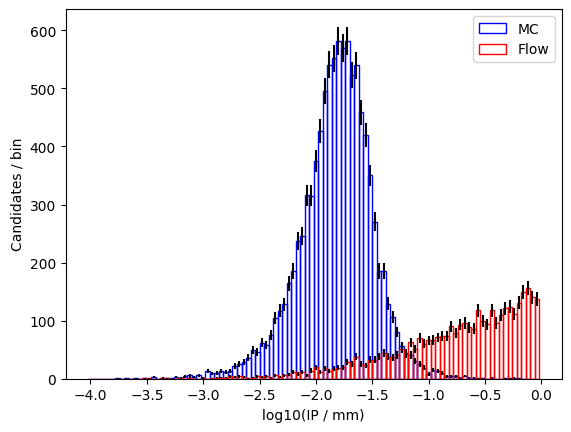

Loss at iteration 200: 0.4188489317893982


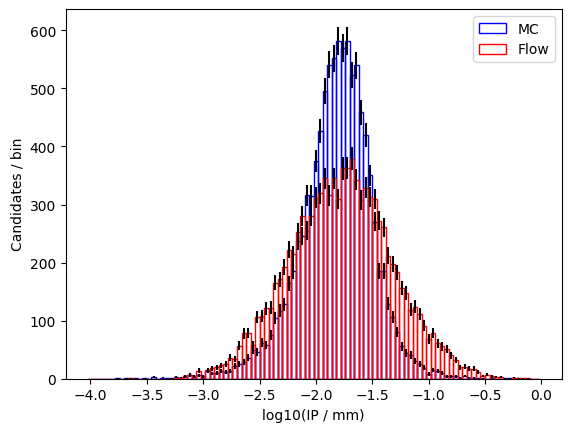

Loss at iteration 400: 0.3348946273326874


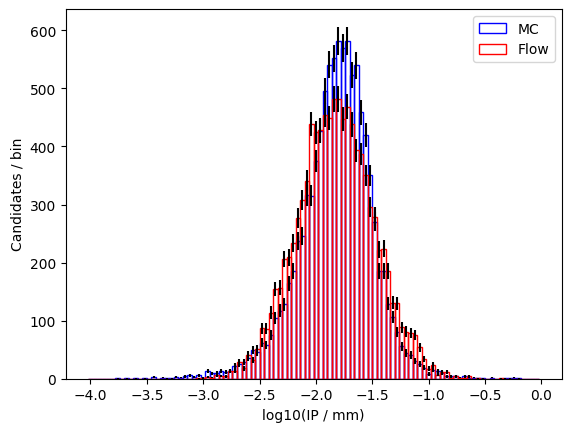

Loss at iteration 600: 0.3348946273326874


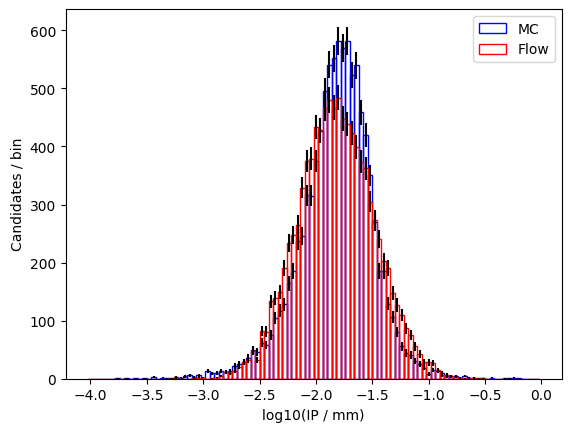

Loss at iteration 800: 0.3348946273326874


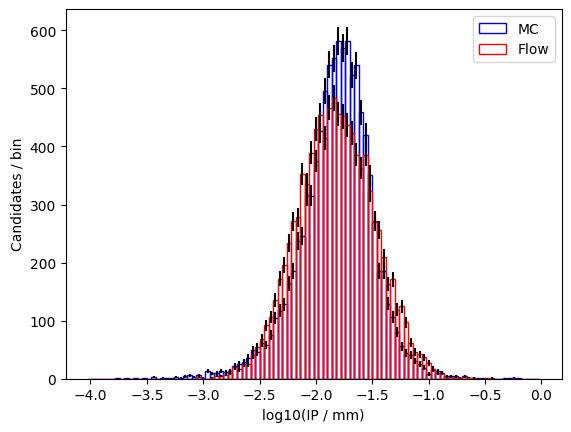

In [22]:
flow_v2 = make_flow(hidden_features=8)
optimizer = optim.Adam(flow_v2.parameters())
train_flow_old_style(flow_v2, optimizer, sim_log10_ip_tensor, n_iter)

Loss at iteration 0: 2.290018081665039


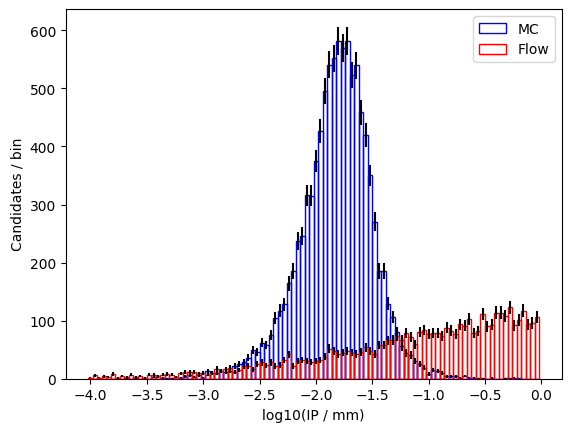

Loss at iteration 200: 0.33489736914634705


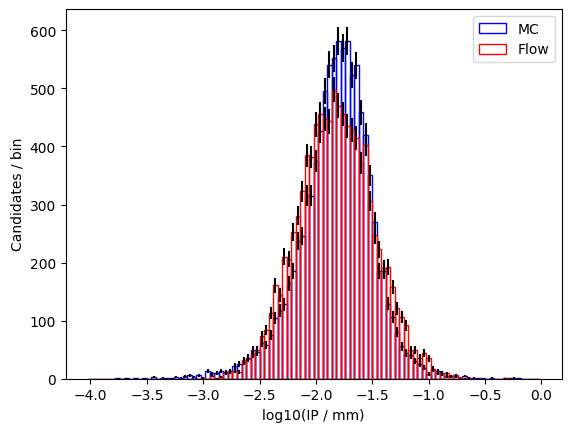

Loss at iteration 400: 0.33489471673965454


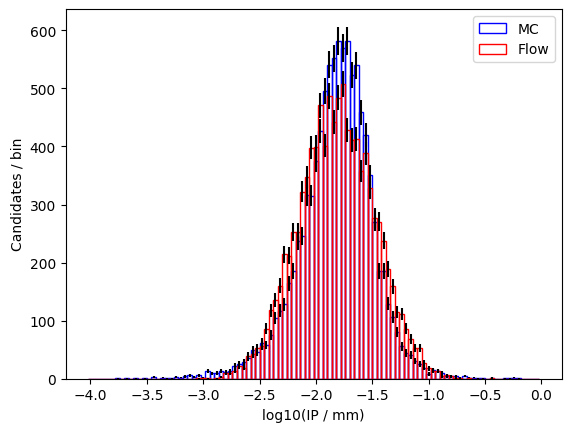

Loss at iteration 600: 0.3348946273326874


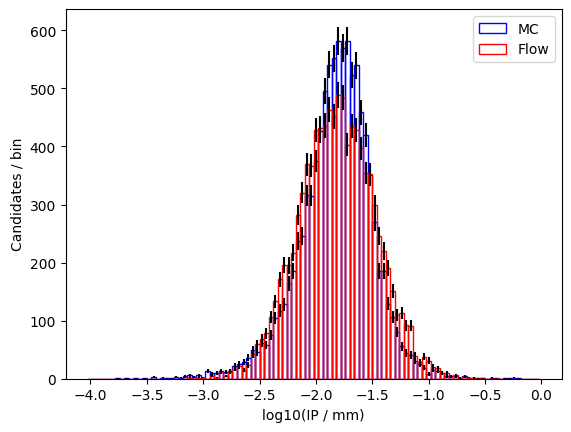

Loss at iteration 800: 0.33489471673965454


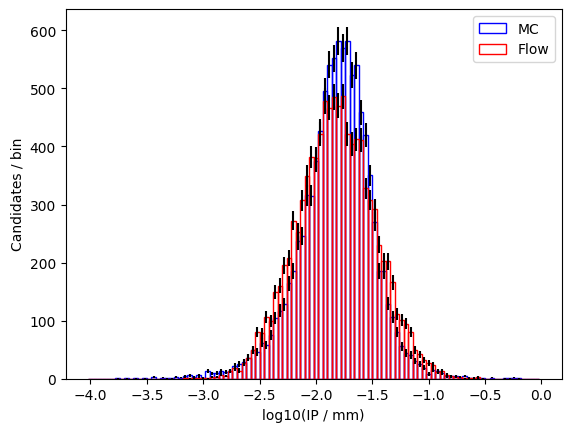

In [23]:
flow_v3 = make_flow(hidden_features=12)
optimizer = optim.Adam(flow_v3.parameters())
train_flow_old_style(flow_v3, optimizer, sim_log10_ip_tensor, n_iter)

So, seems that the number of hidden features isn't really making a difference...
The loss function underneath all this is not binned of course. How does this loss function work?

Reading the paper some more, maybe I start to see it. The KL divergence works by taking the sample from the target, applying the inverse transformation to them,
and evaluating the probability of each of those points as described by the base distribution. So for a Standard Normal, if the forward trans is good, the inverse will al so be good, and you'll get back a good sampling of a standard normal disribution, with probabilities between 0 and 1. It takes the log (thereby transform the [0,1] range to a roughly symmetric range about 0) and takes the mean. In the end, I think the KL divergence should therefore head towards 0. 

But then this makes sense why it might get the *width* wrong: if you think about it it only really gets the mean right. If we have a larger width we just get a bigger symmetric spread about 0 in log (prob) - the mean is still 0. So to first order I reckon this KL divergence can't really be expected to get the variance of the target distribution right. We need to try something else... 

In [24]:
def make_deep_flow(hidden_features=4, num_layers=3):
    N_FEATURES = 1
    _transforms = []
    for _ in range(num_layers):
        _transforms.append(transforms.permutations.ReversePermutation(features=N_FEATURES))
        _transforms.append(transforms.MaskedPiecewiseQuadraticAutoregressiveTransform(features=N_FEATURES, hidden_features=hidden_features))
    transform = transforms.CompositeTransform(_transforms)
    base_distribution = distributions.StandardNormal(shape=[N_FEATURES])
    return flows.Flow(transform=transform, distribution=base_distribution)

In [25]:
def make_different_flow(hidden_features=4):
    N_FEATURES = 1
    transform = transforms.CompositeTransform([
        transforms.MaskedPiecewiseLinearAutoregressiveTransform(features=N_FEATURES, hidden_features=hidden_features, num_bins=8),
        transforms.RandomPermutation(features=N_FEATURES)
    ])
    base_distribution = distributions.StandardNormal(shape=[N_FEATURES])
    return flows.Flow(transform=transform, distribution=base_distribution)

In [26]:
# deep_flow = make_deep_flow(hidden_features=8, num_layers=5)
deep_flow = make_different_flow(hidden_features=8) 
optimizer = optim.Adam(deep_flow.parameters())
train_flow_old_style(deep_flow, optimizer, sim_log10_ip_tensor, n_iter)

InputOutsideDomain: 

Let's have a go at seeing if the flow can map to a different 1D Gaussian with sufficient accuracy (and a good chi2)

tensor([[ 7.1099],
        [ 8.3028],
        [ 4.9314],
        ...,
        [11.3290],
        [13.2297],
        [13.8383]])


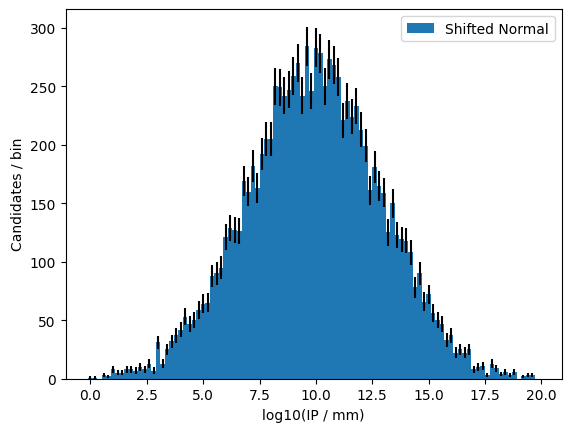

In [27]:
# Shift and scale a unit Gaussian
new_gaus = 3.0*distributions.StandardNormal(shape=[N_FEATURES]).sample(N_SAMPLES) + 10.0
print(new_gaus)

hist, new_bins = np.histogram(new_gaus, bins=100, range=(0, 20))
plt.bar(x=new_bins[:-1], height=hist, yerr=np.sqrt(hist), width=new_bins[1] - new_bins[0], label='Shifted Normal')
plt.xlabel('log10(IP / mm)')
plt.ylabel('Candidates / bin')
plt.legend()
plt.show()

Loss at iteration 0: 48.85361099243164


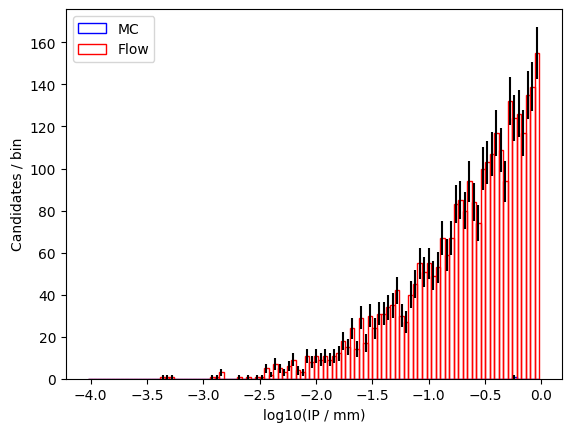

Loss at iteration 200: 3.2040138244628906


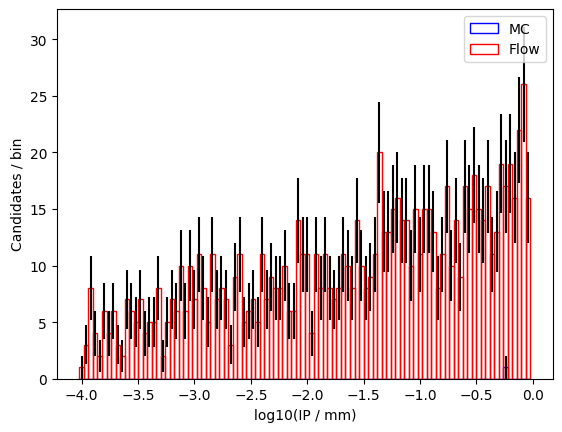

Loss at iteration 400: 2.7263643741607666


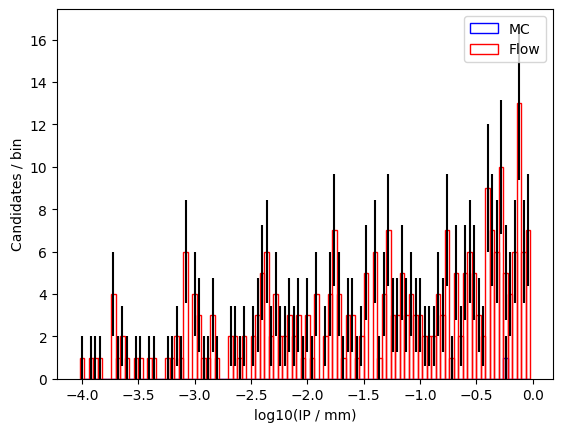

Loss at iteration 600: 2.620366096496582


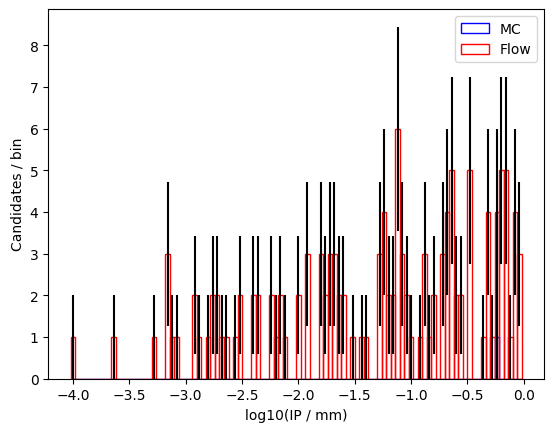

Loss at iteration 800: 2.55234956741333


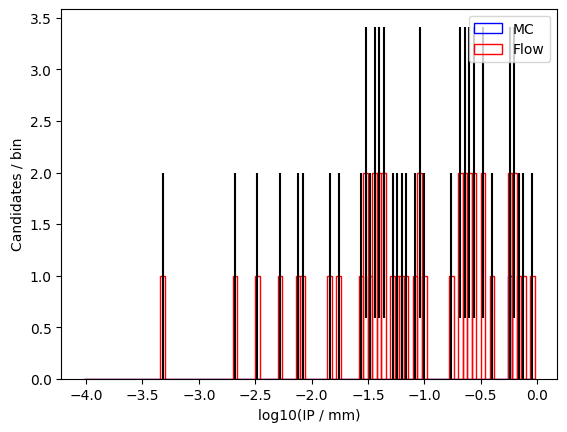

In [28]:
# Flow to it
old_flow = make_flow(hidden_features=4)
optimizer = optim.Adam(old_flow.parameters())
train_flow_old_style(old_flow, optimizer, new_gaus, n_iter)

In [29]:
def train_flow_old_style(flow, optimizer, target_data, n_iter):
    #flow.train() # Put it in training mode.
    for i in range(n_iter):
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs=target_data).mean()
        loss.backward()
        optimizer.step()
        ### Testing the thing
        # flow.eval() # Put it in evaluation mode.
        with torch.inference_mode():
            if i % (n_iter/5) == 0:
                print(f"Loss at iteration {i}: {loss}")

                # Plot the target
                fig, ax = plt.subplots()
                hist_target, bins = np.histogram(target_data, bins=100, range=(-4, 0))

                ax.bar(x=bins[:-1], height=hist_target, yerr=np.sqrt(hist_target), width=bins[1] - bins[0], label='MC', fill=False, edgecolor='blue')
                ax.set_xlabel('log10(IP / mm)')
                ax.set_ylabel('Candidates / bin')

                # Sample from the flow and plot the histogram
                samples = flow.sample(N_SAMPLES)
                pred_hist, bins = np.histogram(samples, bins=100, range=(-4, 0))
                ax.bar(x=bins[:-1], height=pred_hist, yerr=np.sqrt(pred_hist), width=bins[1] - bins[0], label='Flow', fill=False, edgecolor='red')

                ax.legend()
                plt.show()

Loss at iteration 0: 26.632490158081055


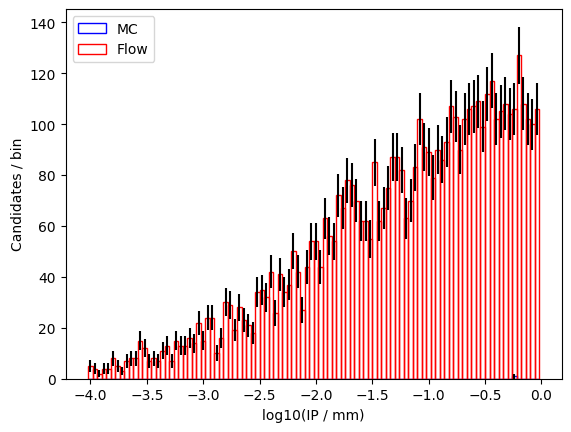

Loss at iteration 200: 4.256608486175537


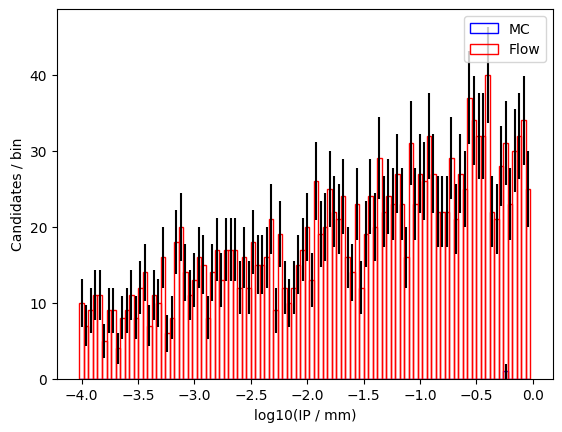

Loss at iteration 400: 2.783360719680786


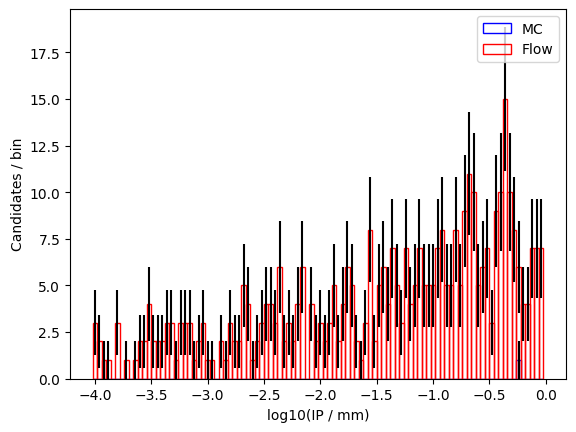

Loss at iteration 600: 2.539041519165039


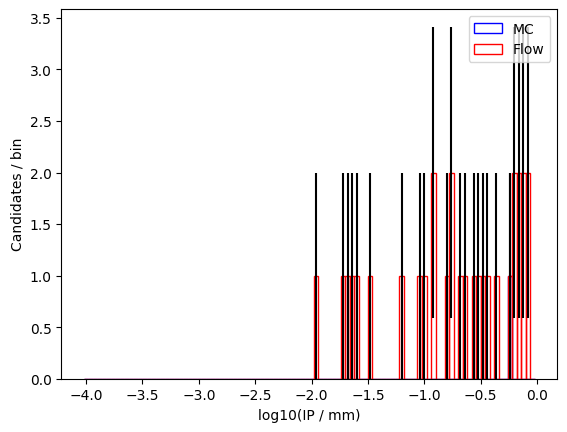

Loss at iteration 800: 2.5120699405670166


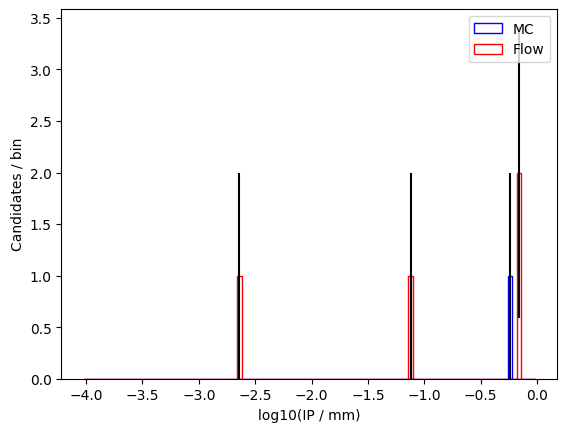

In [30]:
# Flow to it
old_flow = make_flow(hidden_features=4)
optimizer = optim.Adam(old_flow.parameters())
train_flow_old_style(old_flow, optimizer, new_gaus, n_iter)

It is getting there, although being a bit slow about it. Keep going...

Loss at iteration 0: 2.511920213699341


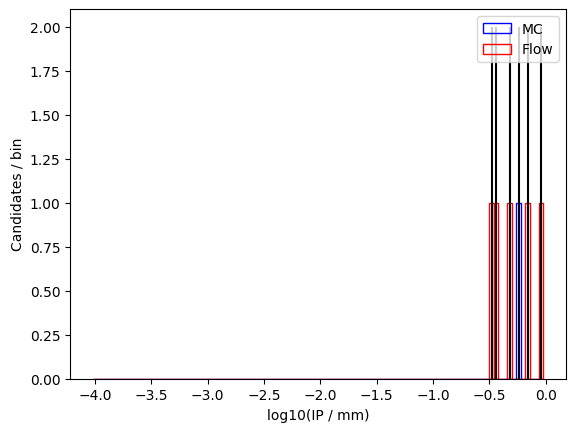

Loss at iteration 200: 2.511920213699341


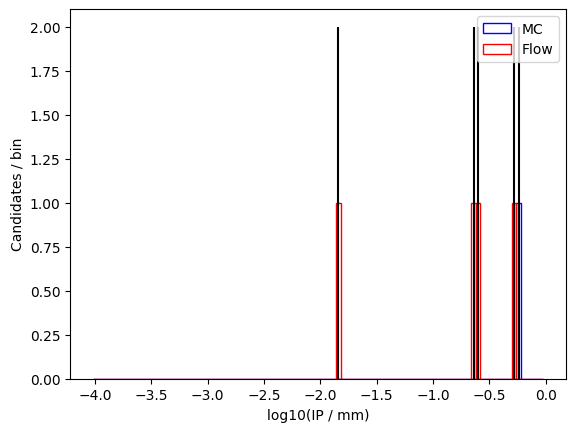

Loss at iteration 400: 2.511920213699341


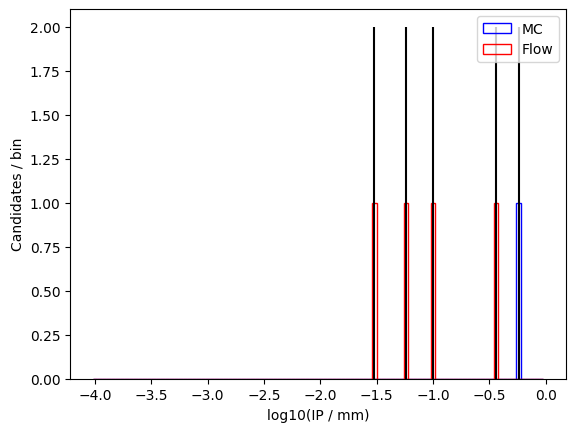

Loss at iteration 600: 2.511920213699341


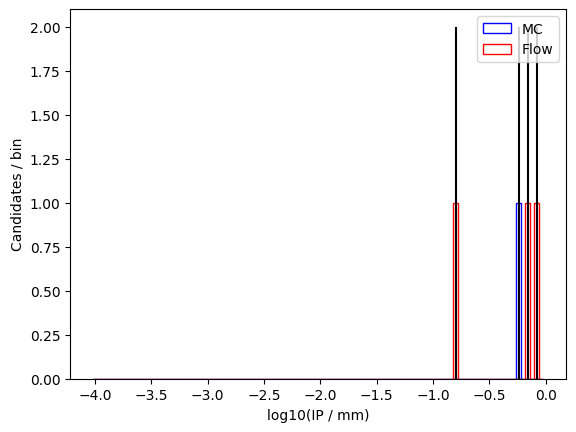

Loss at iteration 800: 2.511920213699341


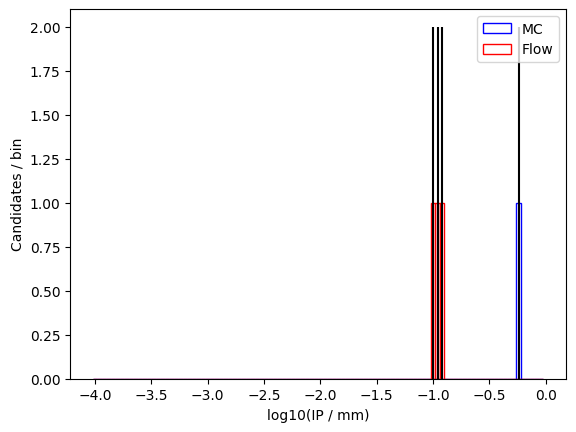

In [31]:
train_flow_old_style(old_flow, optimizer, new_gaus, n_iter)

That looks pretty good. Can we evaluate a chi2? And plot a pull and a ratio?

In [32]:
def benchmark_hep_style(flow, target, ratios_not_pulls=False):
    # PLease use with torch.inference_mode

    # Divide the canvas into 2 vertically
    fig, ax = plt.subplots(2, 1, figsize=(6, 8))

    bin_opts = dict(bins=50, range=(0, 20))
    num_hist, bins = np.histogram(target, **bin_opts)

    samples = flow.sample(N_SAMPLES)
    pred_hist, bins = np.histogram(samples, **bin_opts)

    # Plot the two distributions
    ax[0].bar(x=bins[:-1], height=num_hist, yerr=np.sqrt(num_hist), width=bins[1] - bins[0], label='MC', fill=False)
    ax[0].bar(x=bins[:-1], height=pred_hist, yerr=np.sqrt(pred_hist), width=bins[1] - bins[0], label='Flow', fill=False, edgecolor='red', capsize=0)

    # Evaluate a chi2 - treat them as two independent distributions
    resid = np.where(np.isclose(num_hist, 0), 0, (num_hist - pred_hist)**2 / (np.abs(num_hist) + np.abs(pred_hist)))
    chi2 = np.sum(resid)
    nbins = len(num_hist)
    print(f"Chi2/nbins: {chi2}/{nbins} = {chi2/nbins}")
    
    if ratios_not_pulls:
        ratio = num_hist / pred_hist
        ax[1].axhline(y=1, color='gray', linestyle='--')
        ax[1].errorbar(x=bins[:-1], y=ratio, yerr=np.sqrt((ratio**2 / np.abs(num_hist)) + (ratio**2/np.abs(pred_hist))), xerr=bins[1] - bins[0], label='Ratio', ls='')
        ax[1].set_ylabel('Ratio')
    else:
        # Calculate pull histogram
        pull = (num_hist - pred_hist) / np.sqrt(np.abs(num_hist) + np.abs(pred_hist))
        ax[1].bar(x=bins[:-1], height=pull, yerr=np.zeros_like(pull), width=bins[1] - bins[0], label='Pull', fill=True, edgecolor='blue')
        ax[1].set_ylabel('Pull')
        print(f"The sum of squared residuals is {np.sum(pull**2)}")
    ax[1].set_xlabel('log10(IP / mm)')

    plt.show()

Chi2/nbins: 41.75648865781178/50 = 0.8351297731562356
The sum of squared residuals is 41.75648865781178


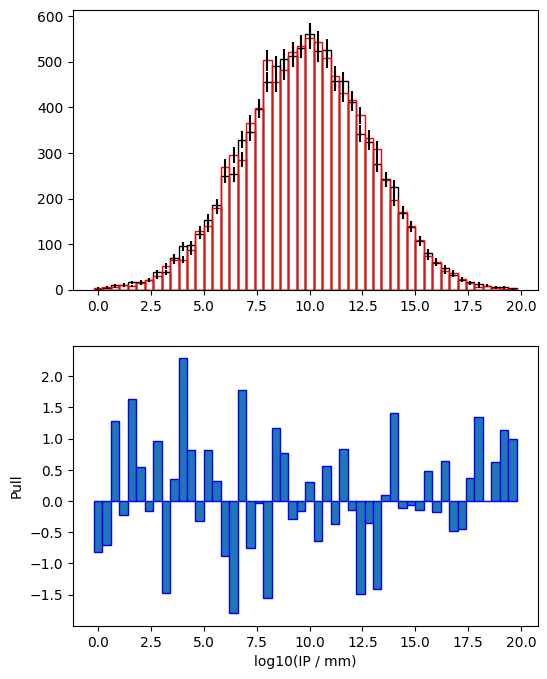

Chi2/nbins: 35.27182945581488/50 = 0.7054365891162976


/tmp/ipykernel_62671/546652052.py:24: RuntimeWarning: divide by zero encountered in divide
  ratio = num_hist / pred_hist
/home/epp/phrrkw/.local/lib/python3.9/site-packages/matplotlib/axes/_axes.py:3683: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err


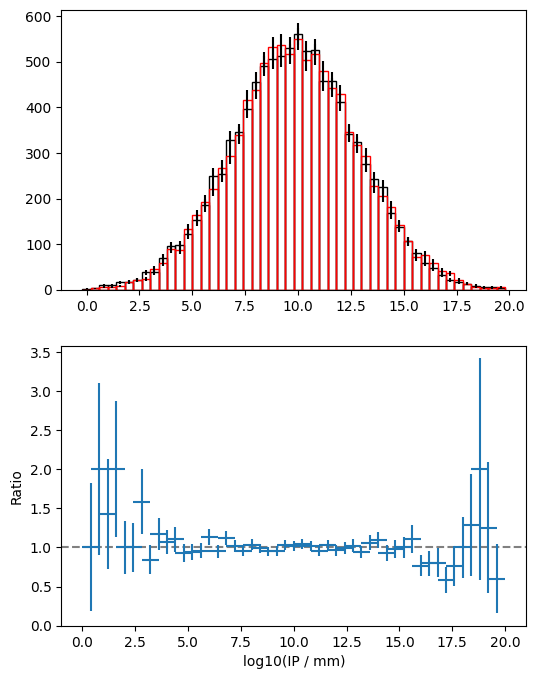

In [33]:
with torch.inference_mode():
    torch.manual_seed(50)
    benchmark_hep_style(old_flow, new_gaus)
    benchmark_hep_style(old_flow, new_gaus, ratios_not_pulls=True)

So, looks like we can flow perfectly well to another Gaussian, but flowing to my not-quite-Gaussian is more tricky.
I probably need a different type of flow, one with more expressive power. I've already tried changing the learning rate, the number of hidden features as well.
Back to the paper I guess.

In [38]:
def make_stacked_flow(hidden_features=4, num_layers=2):
    N_FEATURES = 1
    _transforms = []
    for _ in range(num_layers):
        _transforms.append(transforms.ReversePermutation(features=N_FEATURES))
        _transforms.append(transforms.MaskedAffineAutoregressiveTransform(features=N_FEATURES, hidden_features=hidden_features))
    transform = transforms.CompositeTransform(_transforms)
    base_distribution = distributions.StandardNormal(shape=[N_FEATURES])
    return flows.Flow(transform=transform, distribution=base_distribution)

Loss at iteration 0: 5.309653282165527


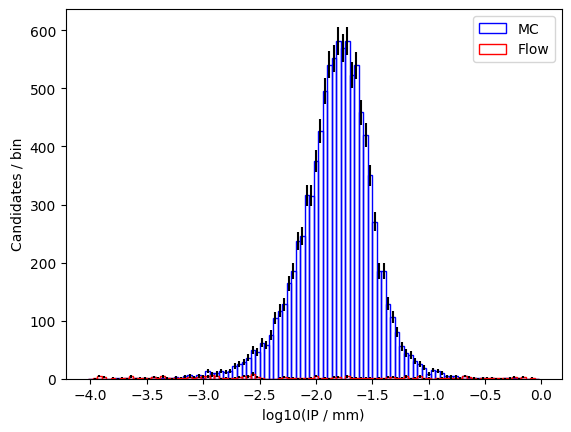

Loss at iteration 200: 0.33489474654197693


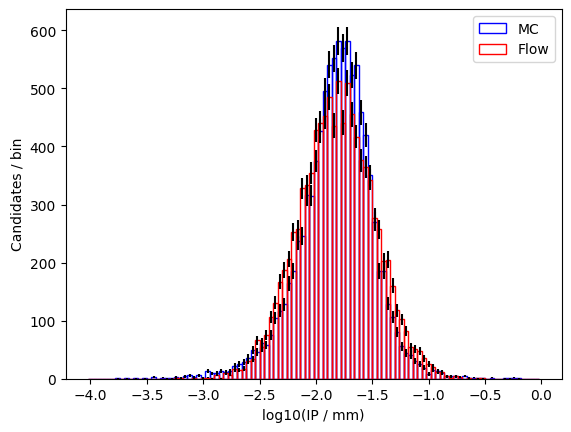

Loss at iteration 400: 0.33489465713500977


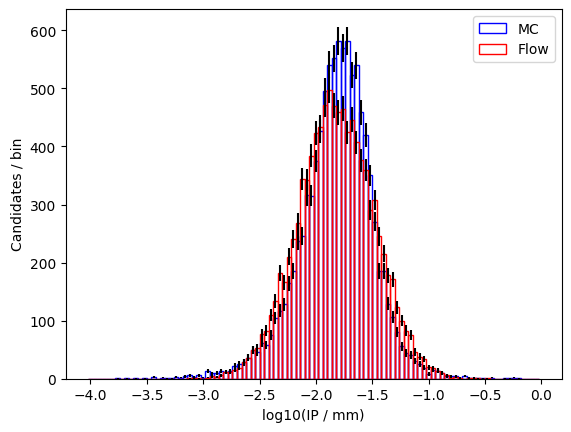

Loss at iteration 600: 0.3348945677280426


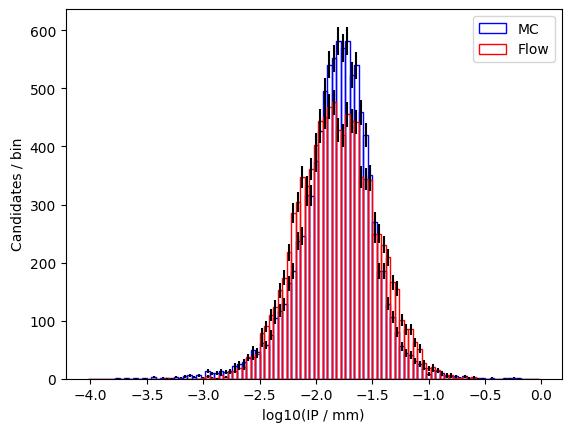

Loss at iteration 800: 0.3348946273326874


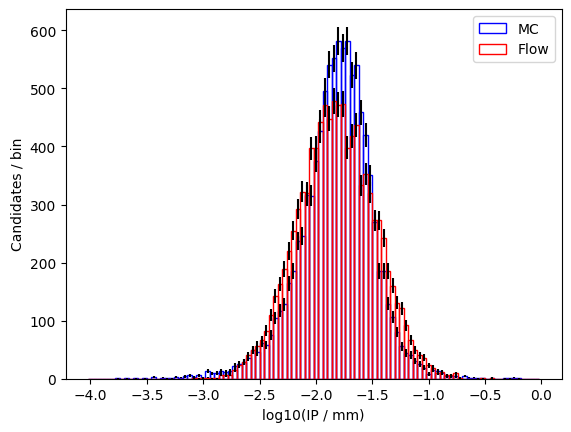

In [42]:
# Flow to it
# I've tried 4 features and 32 layers
stacked_flow = make_stacked_flow(hidden_features=8, num_layers=10)
optimizer = optim.Adam(stacked_flow.parameters())
train_flow_old_style(stacked_flow, optimizer, sim_log10_ip_tensor, n_iter=1000 )

In [48]:
def make_real_nvp_flow(hidden_features=8, num_layers=4, num_blocks_per_layer=2):
    N_FEATURES = 1
    # transform = 
    #base_distribution = distributions.StandardNormal(shape=[N_FEATURES])
    return flows.SimpleRealNVP(features=N_FEATURES, hidden_features=hidden_features, num_layers=num_layers, num_blocks_per_layer=num_blocks_per_layer,)#flows.Flow(transform=transform, distribution=base_distribution)

/home/epp/phrrkw/.local/lib/python3.9/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Loss at iteration 0: 2.210968017578125


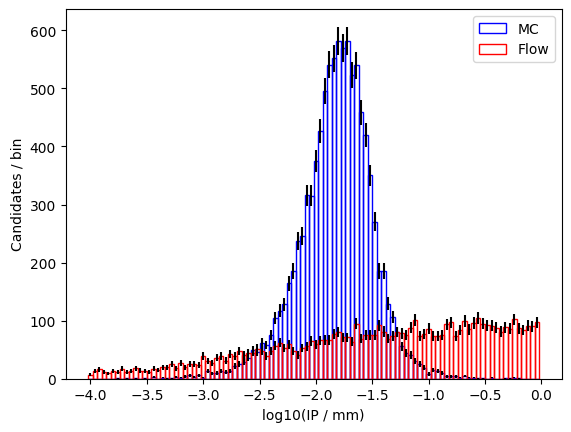

Loss at iteration 200: 0.9722143411636353


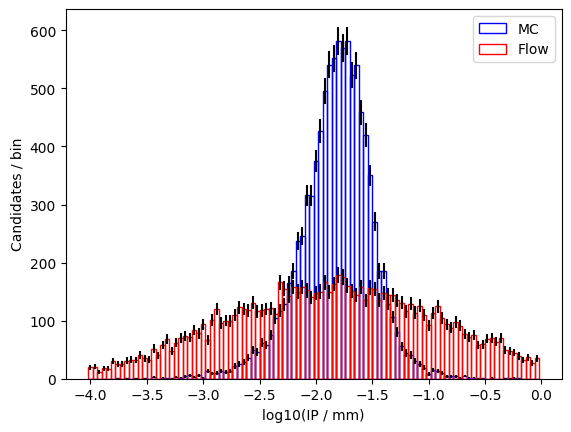

Loss at iteration 400: 0.9719372987747192


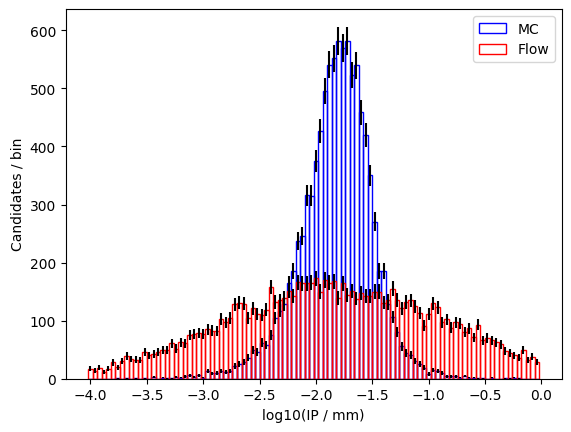

Loss at iteration 600: 0.9766402244567871


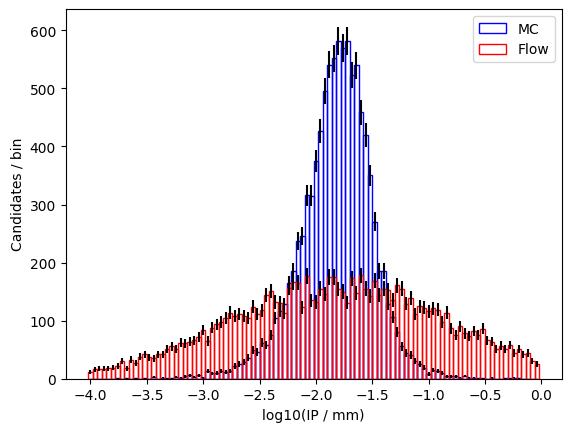

Loss at iteration 800: 0.9718274474143982


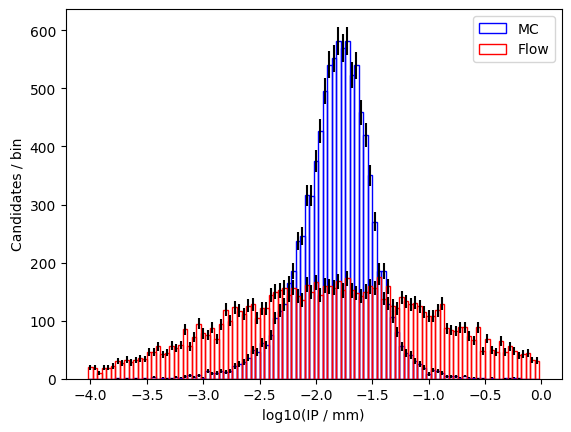

In [57]:
real_nvp_flow = make_real_nvp_flow(num_layers=10, hidden_features=8, num_blocks_per_layer=32)
optimizer = optim.Adam(real_nvp_flow.parameters())
train_flow_old_style(real_nvp_flow, optimizer, sim_log10_ip_tensor, n_iter=1000 )

# Tried:
# 8 hidden features, 4 layers, 2 blocks per layer, 1000 iters. Gets broad and flat and stuck at 0.97 
# and lr down to 0.01, 0.1 and 0.01 didnt do owt
# hidden features up to 16 made no difference
# with 10 layers it seems to be slowly improving... but only gets down to 0.972. Still broad and flat 
# 10 layers, 8 features did nowt


In [91]:
# Can my original model flow to something non Gaussian at all? 
# Reading this comment/issue https://github.com/bayesiains/nflows/issues/73 it seems my 1 MAF is indeed doomed, it's just a Gaussian -> Gaussian transform
# The person there suggests a spline, and points to an abstract: https://papers.nips.cc/paper_files/paper/2019/hash/7ac71d433f282034e088473244df8c02-Abstract.html
# They seem to suggest a monotonic rational-quadratic spline. 
# THere seems to be a PiecewiseRationalQuadraticCDF in nflows, so let's try that
def make_quad_flow(hidden_features=8, num_layers=2):
    N_FEATURES = 1
    return flows.Flow(transform=transforms.PiecewiseRationalQuadraticCDF(shape=N_FEATURES, tails='linear', tail_bound=4, num_bins=3 ), distribution=distributions.StandardNormal(shape=[N_FEATURES]))

Loss at iteration 0: 4.764047145843506


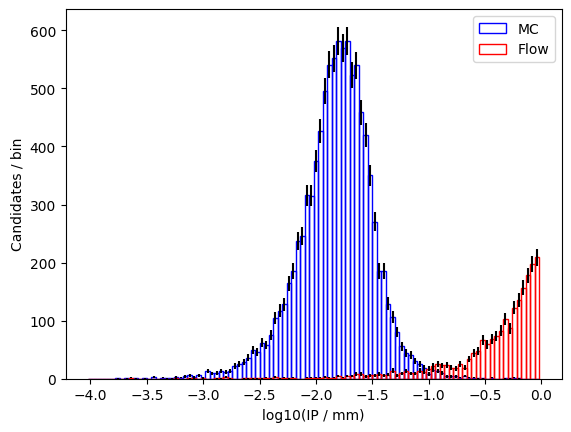

Loss at iteration 2000: 0.2912912666797638


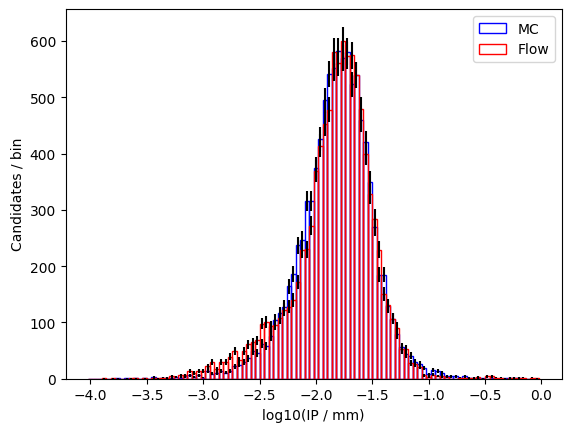

Loss at iteration 4000: 0.2765451669692993


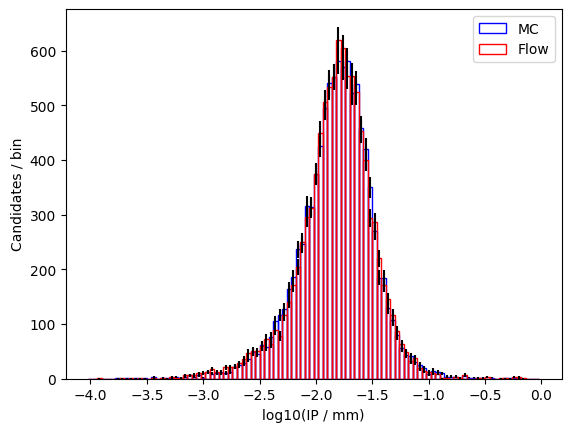

Loss at iteration 6000: 0.2742026150226593


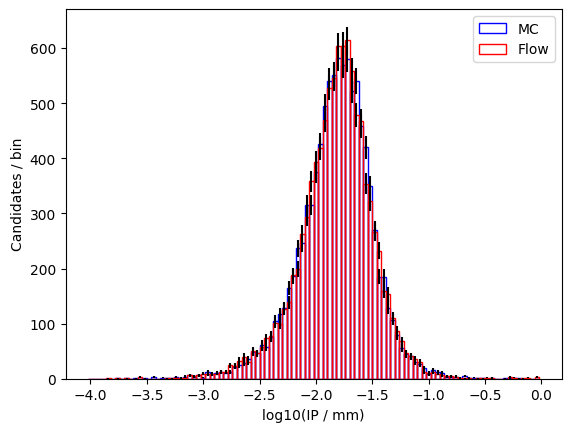

Loss at iteration 8000: 0.2738838493824005


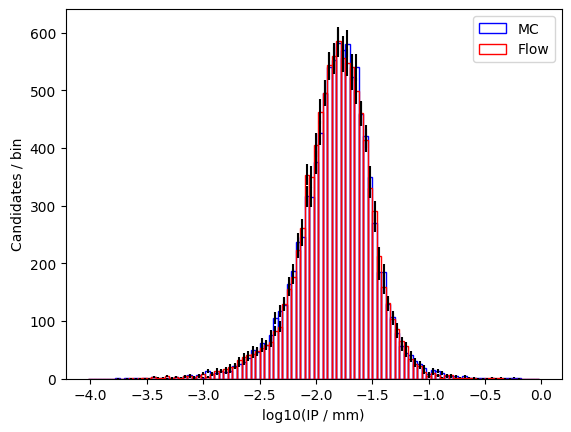

In [95]:
torch.manual_seed(50)
quad_flow = make_quad_flow()
optimizer = optim.Adam(quad_flow.parameters())
train_flow_old_style(quad_flow, optimizer, sim_log10_ip_tensor, n_iter=10000 )

It works!! Now we need to benchmark that hep style

In [97]:
def benchmark_hep_style(flow, target, ratios_not_pulls=False):
    # PLease use with torch.inference_mode

    # Divide the canvas into 2 vertically
    fig, ax = plt.subplots(2, 1, figsize=(6, 8))

    bin_opts = dict(bins=50, range=(-4, 0))
    num_hist, bins = np.histogram(target, **bin_opts)

    samples = flow.sample(N_SAMPLES)
    pred_hist, bins = np.histogram(samples, **bin_opts)

    # Plot the two distributions
    ax[0].bar(x=bins[:-1], height=num_hist, yerr=np.sqrt(num_hist), width=bins[1] - bins[0], label='MC', fill=False)
    ax[0].bar(x=bins[:-1], height=pred_hist, yerr=np.sqrt(pred_hist), width=bins[1] - bins[0], label='Flow', fill=False, edgecolor='red', capsize=0)

    # Evaluate a chi2 - treat them as two independent distributions
    resid = np.where(np.isclose(num_hist, 0), 0, (num_hist - pred_hist)**2 / (np.abs(num_hist) + np.abs(pred_hist)))
    chi2 = np.sum(resid)
    nbins = len(num_hist)
    print(f"Chi2/nbins: {chi2}/{nbins} = {chi2/nbins}")
    
    if ratios_not_pulls:
        ratio = num_hist / pred_hist
        ax[1].axhline(y=1, color='gray', linestyle='--')
        ax[1].errorbar(x=bins[:-1], y=ratio, yerr=np.sqrt((ratio**2 / np.abs(num_hist)) + (ratio**2/np.abs(pred_hist))), xerr=bins[1] - bins[0], label='Ratio', ls='')
        ax[1].set_ylabel('Ratio')
    else:
        # Calculate pull histogram
        pull = (num_hist - pred_hist) / np.sqrt(np.abs(num_hist) + np.abs(pred_hist))
        ax[1].bar(x=bins[:-1], height=pull, yerr=np.zeros_like(pull), width=bins[1] - bins[0], label='Pull', fill=True, edgecolor='blue')
        ax[1].set_ylabel('Pull')
        print(f"The sum of squared residuals is {np.sum(pull**2)}")
    ax[1].set_xlabel('log10(IP / mm)')

    plt.show()

Chi2/nbins: 40.326677468077186/50 = 0.8065335493615438
The sum of squared residuals is nan


/tmp/ipykernel_62671/2245982504.py:18: RuntimeWarning: invalid value encountered in divide
  resid = np.where(np.isclose(num_hist, 0), 0, (num_hist - pred_hist)**2 / (np.abs(num_hist) + np.abs(pred_hist)))
/tmp/ipykernel_62671/2245982504.py:30: RuntimeWarning: invalid value encountered in divide
  pull = (num_hist - pred_hist) / np.sqrt(np.abs(num_hist) + np.abs(pred_hist))


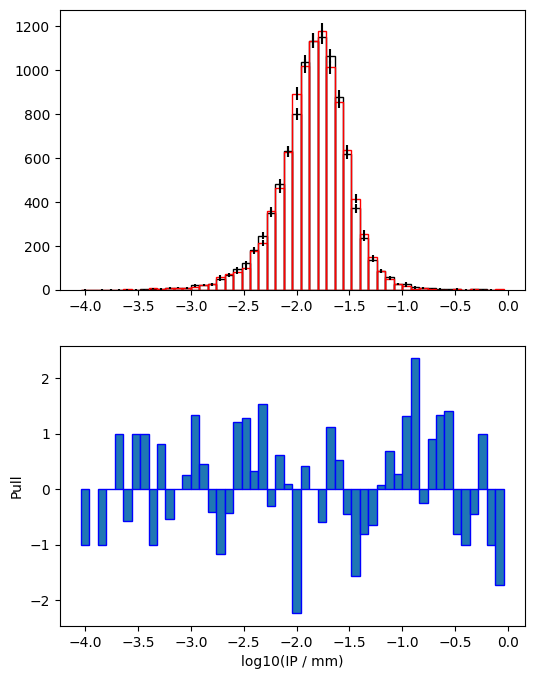

Chi2/nbins: 33.06337985431386/50 = 0.6612675970862771


/tmp/ipykernel_62671/2245982504.py:24: RuntimeWarning: divide by zero encountered in divide
  ratio = num_hist / pred_hist
/tmp/ipykernel_62671/2245982504.py:24: RuntimeWarning: invalid value encountered in divide
  ratio = num_hist / pred_hist
/tmp/ipykernel_62671/2245982504.py:26: RuntimeWarning: invalid value encountered in divide
  ax[1].errorbar(x=bins[:-1], y=ratio, yerr=np.sqrt((ratio**2 / np.abs(num_hist)) + (ratio**2/np.abs(pred_hist))), xerr=bins[1] - bins[0], label='Ratio', ls='')
/home/epp/phrrkw/.local/lib/python3.9/site-packages/matplotlib/axes/_axes.py:3683: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err


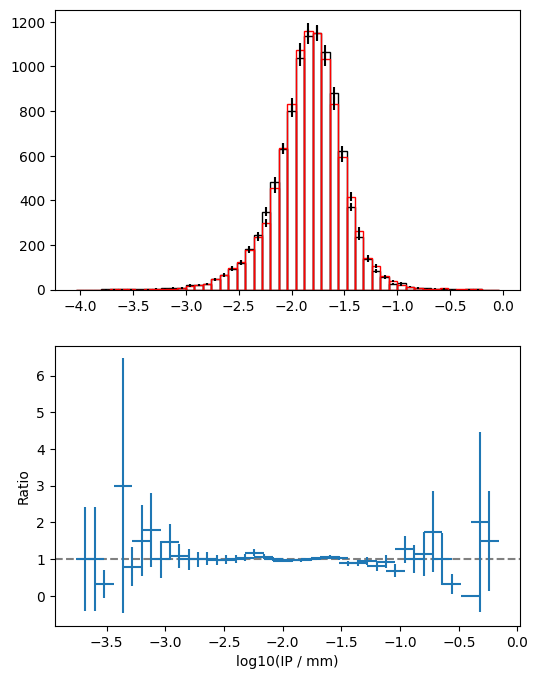

In [98]:
with torch.inference_mode():
    torch.manual_seed(50)
    benchmark_hep_style(quad_flow, sim_log10_ip_tensor)
    benchmark_hep_style(quad_flow, sim_log10_ip_tensor, ratios_not_pulls=True)

'Tis a thing of beauty. There is your first flow to the LHCb MC log10(IP) distribution.